In [1]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import pyomo.core as pyoc
import pyomo.core.kernel.piecewise_library.transforms_nd as pyotnd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import floor
from scipy.spatial import Delaunay

## Solving MILNP with global linearization approaches

In this notebook, simple scheduling formulations with non-linear objective functions are investigated. We use [this example](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/04.03-Job-Shop-Scheduling.html) as base for the problem formulation.

We are given a set of jobs $J$ to be produced in the set of machines $M$. The objective is to minimize the overall production cost, which is a non-linear function that penalizes the idle time of each task:

$$ min \sum_{j \in J} f(start_j, idle_j) $$

#### Baseline scheduling problem
Now, the scheduling optimization problem is defined. As a baseline, we implement the original version that minimizes the makespan.

In [2]:
class BaseSchedulingProblem:
    
    def initialize(self, tasks):
        self._tasks = tasks
        self._model = pyo.ConcreteModel()
        self._define_sets(self._model)
        self._define_parameters(self._model)
        self._define_decision_variables(self._model)
        self._define_scheduling_constraints(self._model)
        self._define_objective(self._model)
    
    def _define_objective(self, model):
        # define a new decision variable
        model.makespan = pyo.Var(bounds=(0, self._ub))
        # add makespan constraint
        model.finish = pyo.Constraint(model.TASKS, rule=lambda model, j, m:  
            model.start[j,m] + model.dur[j,m] <= model.makespan)
        # and finally the objective
        model.objective = pyo.Objective(expr = model.makespan, sense = pyo.minimize)

    def _define_decision_variables(self, model):
        model.start = pyo.Var(model.TASKS, bounds=(0, self._ub))
        model.idle = pyo.Var(model.TASKS, bounds=(0, self._ub)) # slack variable to take into account the time between machines
        model.end = pyo.Var(model.TASKS, bounds=(0, self._ub)) # auxiliary variable to define the end time of a task in a machine

    def _define_scheduling_constraints(self, model):
        model.preceding = pyo.Constraint(model.TASKORDER, rule=lambda model, j, m, k, n: 
            model.start[k,n] + model.dur[k,n] + model.idle[k,n] == model.start[j,m]) 
        
        model.end_time = pyo.Constraint(model.TASKS, rule=lambda model, j, m:  
            model.end[j,m] == model.start[j,m] + model.dur[j,m] + model.idle[j,m])
        
        model.disjunctions = gdp.Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
            [model.start[j,m] + model.dur[j,m]<= model.start[k,m], 
            model.start[k,m] + model.dur[k,m] <= model.start[j,m]])
     
        pyo.TransformationFactory('gdp.hull').apply_to(model)
       
    def _define_parameters(self, model):
        # load duration data into a model parameter for later access
        model.dur = pyo.Param(model.TASKS, initialize=lambda model, j, m: self._tasks[(j,m)]['dur'])
        model.min_dur = pyo.Param(model.TASKS, initialize=lambda model, j, m: self._tasks[(j,m)]['min_dur'])
        model.max_dur = pyo.Param(model.TASKS, initialize=lambda model, j, m: self._tasks[(j,m)]['max_dur'])
        # define the UB
        self._ub = sum([model.dur[j,m] for (j,m) in model.TASKS])
        

    def _define_sets(self, model):
        # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
        model.TASKS = pyo.Set(initialize = self._tasks.keys(), dimen=2)
        
        # the set of jobs is constructed from a python set
        model.JOBS = pyo.Set(initialize = list(set([j for (j,m) in model.TASKS])))
        
        # set of machines is constructed from a python set
        model.MACHINES = pyo.Set(initialize = list(set([m for (j,m) in model.TASKS])))
        
        # the order of tasks is constructed as a cross-product of tasks and filtering
        model.TASKORDER = pyo.Set(initialize = model.TASKS * model.TASKS, dimen=4, 
            filter = lambda model, j, m, k, n: (k,n) == self._tasks[(j,m)]['prec'])
        
        # the set of disjunctions is cross-product of jobs, jobs, and machines
        model.DISJUNCTIONS = pyo.Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
            filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    def _get_solution(self, sol, model):
        print(f'Solution status: {sol.solver.status}')
        print(f'Termination condition: {sol.solver.termination_condition}')
        if ((sol.solver.status == pyo.SolverStatus.ok) and (sol.solver.termination_condition == pyo.TerminationCondition.optimal)) or (sol.solver.termination_condition == pyo.TerminationCondition.maxTimeLimit):
            results = [{'Job': j,
                        'Machine': m,
                        'Start': model.start[(j, m)](), 
                        'Duration': model.dur[(j,m)], 
                        'Idle': model.idle[(j, m)](), 
                        'Finish': model.start[(j, m)]() + model.dur[(j,m)],
                        'End': model.end[(j, m)]()}
                    for j,m in model.TASKS]
            return results
        return {}

    def solve(self, log=False, timeLimit=60):
        opt = pyo.SolverFactory('gurobi')
        opt.options = {'TimeLimit': timeLimit}
        sol = opt.solve(self._model, tee=log)
        return self._get_solution(sol, self._model)

    def visualize(self, results):
        schedule = pd.DataFrame(results)
        JOBS = sorted(list(schedule['Job'].unique()))
        MACHINES = sorted(list(schedule['Machine'].unique()))
        makespan = schedule['Finish'].max()
        
        bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
        idle_bar_style = {'alpha':0.5, 'lw':25, 'solid_capstyle':'butt'}
        text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
        colors = mpl.cm.Dark2.colors

        schedule.sort_values(by=['Job', 'Start'])
        schedule.set_index(['Job', 'Machine'], inplace=True)

        fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

        for jdx, j in enumerate(JOBS, 1):
            for mdx, m in enumerate(MACHINES, 1):
                if (j,m) in schedule.index:
                    xs = schedule.loc[(j,m), 'Start']
                    xf = schedule.loc[(j,m), 'Finish']
                    
                    ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                    ax[0].text((xs + xf)/2, jdx, m, **text_style)
                    ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                    ax[1].text((xs + xf)/2, mdx, j, **text_style)

                    xe = schedule.loc[(j,m), 'End']
                    ax[0].plot([xf, xe], [jdx]*2, c='gray', **idle_bar_style)
                    
        ax[0].set_title('Job Schedule')
        ax[0].set_ylabel('Job')
        ax[1].set_title('Machine Schedule')
        ax[1].set_ylabel('Machine')
        
        for idx, s in enumerate([JOBS, MACHINES]):
            ax[idx].set_ylim(0.5, len(s) + 0.5)
            ax[idx].set_yticks(range(1, 1 + len(s)))
            ax[idx].set_yticklabels(s)
            ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
            ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
            ax[idx].set_xlabel('Time')
            ax[idx].grid(True)
            
        fig.tight_layout()

We now construct a function to build recipes and test if the model is running as expected:

In [3]:
def recipe_to_tasks(jobs, machines, durations):
    TASKS = {}
    for j in jobs:
        prec = (None,None)
        for m,d in zip(machines,durations):
            task = (j,m)
            if prec == (None,None):
                TASKS.update({(j,m): {'dur': d, 'min_dur': d, 'max_dur': floor(2.5*d), 'prec': None}})
            else:
                TASKS.update({(j,m): {'dur': d, 'min_dur': d, 'max_dur': floor(2.5*d), 'prec': prec}})
            prec = task
    return TASKS

# define the problem instance
makespan = BaseSchedulingProblem()

Solution status: ok
Termination condition: optimal
Makespan = 26.5


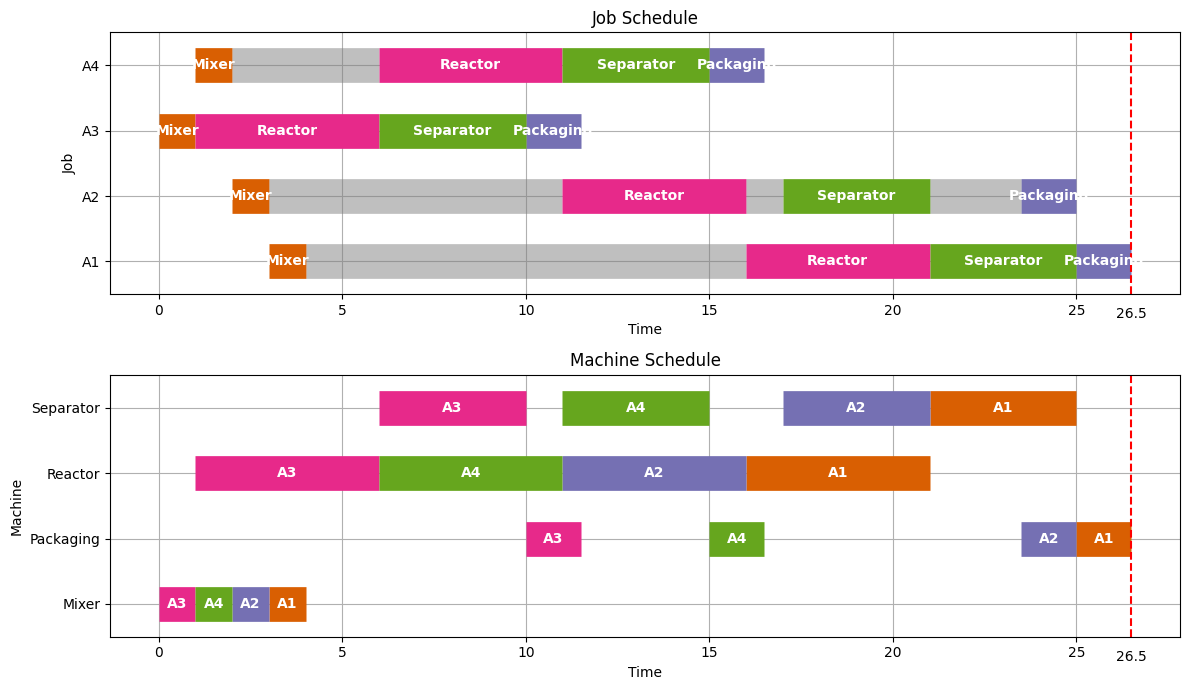

In [4]:
# SCENARIO 1: one product, overlapping jobs
tasks = recipe_to_tasks(['A1','A2','A3', 'A4'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
makespan.initialize(tasks)
results = makespan.solve()
makespan.visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

Solution status: ok
Termination condition: optimal
Makespan = 27.999999997099767


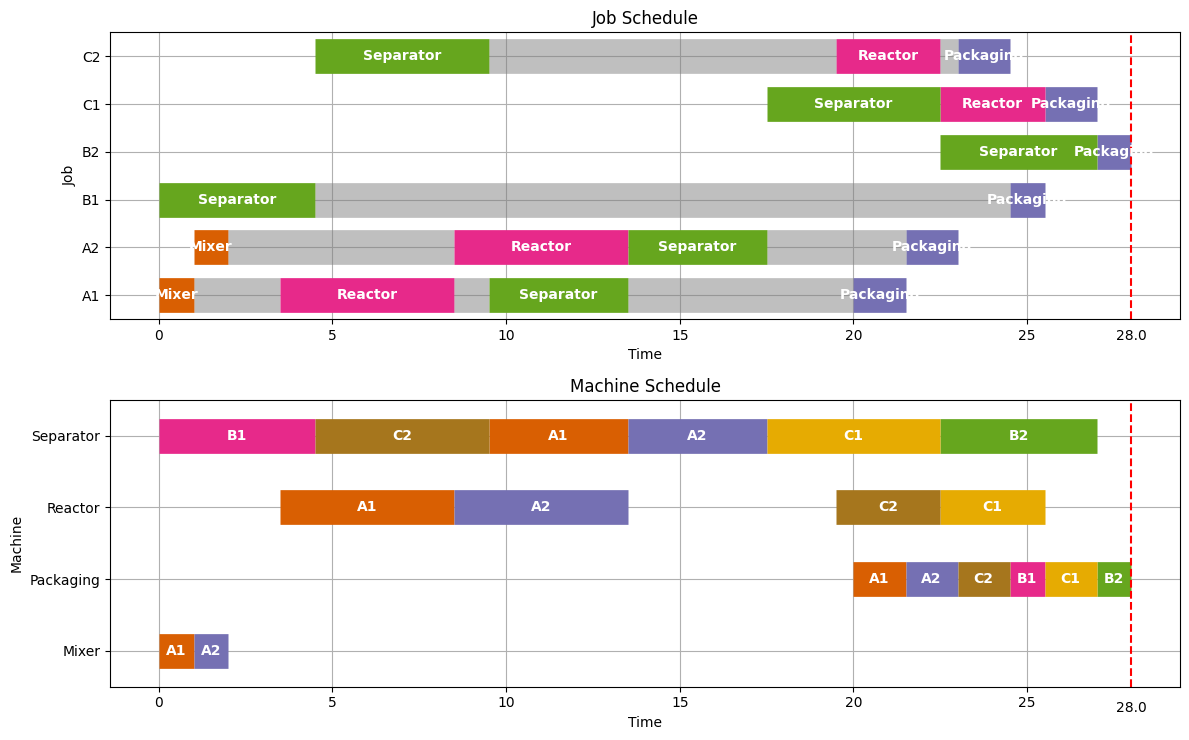

In [5]:
# SCENARIO 2: three products, overlapping jobs
tasks = recipe_to_tasks(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[1,5,4,1.5])
tasks.update(recipe_to_tasks(['B1','B2'],['Separator','Packaging'],[4.5,1]))
tasks.update(recipe_to_tasks(['C1','C2'],['Separator','Reactor','Packaging'],[5,3,1.5]))

makespan.initialize(tasks)
results = makespan.solve()
makespan.visualize(results)
print("Makespan =", max([task['Finish'] for task in results]))

#### Including the non-linear objective
 
So far so good! The implementation is returning similar results from the reference tutorial. Now, we start making things more interesting by including a non-linear objective function. The function $f(.)$ is modeled as:

$$ f(x, f_0, z) = f_0 (1 + e^{-\alpha (x^{\beta/z})} )$$

where $f_0$ represents the initial state of $f$ and $z$ a dynamic scaling factor.

In [6]:
def fobj_multivariate(x, f0, z, alpha=5, beta=-0.3, eta = 0.0001):
    return f0 + f0 * np.exp(-alpha*(np.power(x + eta, beta)/z))

We now see the effect of each variable in the function. First, let's change the scaling factor value $z$ while keeping the other variables fixed:

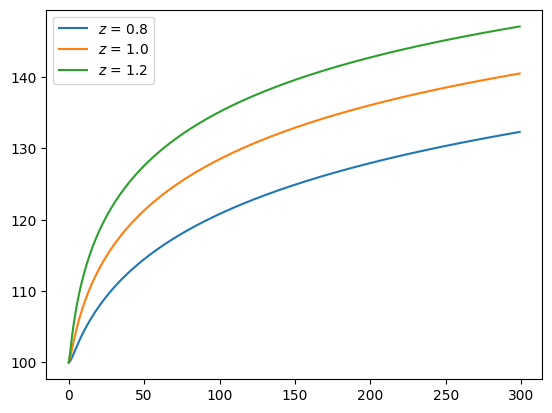

In [7]:
x = np.arange(0, 300)
y1 = fobj_multivariate(x, 100, 0.8)
y2 = fobj_multivariate(x, 100, 1.0)
y3 = fobj_multivariate(x, 100, 1.2)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend(['$z$ = 0.8', '$z$ = 1.0', '$z$ = 1.2'])

Now, let's change the value of the initial function value $f_0$: 

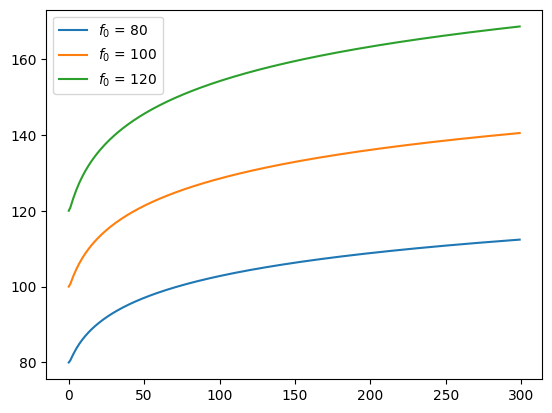

In [8]:
x = np.arange(0, 300)
y1 = fobj_multivariate(x, 80, 1.0)
y2 = fobj_multivariate(x, 100, 1.0)
y3 = fobj_multivariate(x, 120, 1.0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend(['$f_0$ = 80', '$f_0$ = 100', '$f_0$ = 120'])

#### Including the non-linear function into the scheduling problem

In [14]:
class MultivariateNonLinearSchedulingProblem(BaseSchedulingProblem):
    def __init__(self, triangulation, **args) -> None:
        """
            gridpoints: the ordered set of (x,y) pairs defined for the interpolation 
        """
        self._triangulation = triangulation
        self._args = args
    
    def _define_objective(self, model: pyo.ConcreteModel):
        """ The original objective function is overriden
        and the linearizations are now applied.
        """
        # define the new decision variable for the objective function
        model.cost = pyo.Var(model.TASKS, bounds=(0, None))
        for j,m in model.TASKS:
            var_list = [model.start[j,m], model.idle[j,m]]
            piecewise = pyotnd.piecewise_nd(self._triangulation['tri'],        
                                        values=self._triangulation['values'],    
                                        input=var_list,
                                        output=model.cost[j,m],
                                        bound='eq',
                                        repn='cc')            
            setattr(model, f'piecewise_{j}_{m}', piecewise)
            #model.add_component(f'piecewise_{j}_{m}', piecewise) - this fails
        model.objective = pyo.Objective(expr = sum([model.cost[j,m] for j,m in model.TASKS]), sense = pyo.minimize)

Solution status: ok
Termination condition: optimal
Objective: 0.0


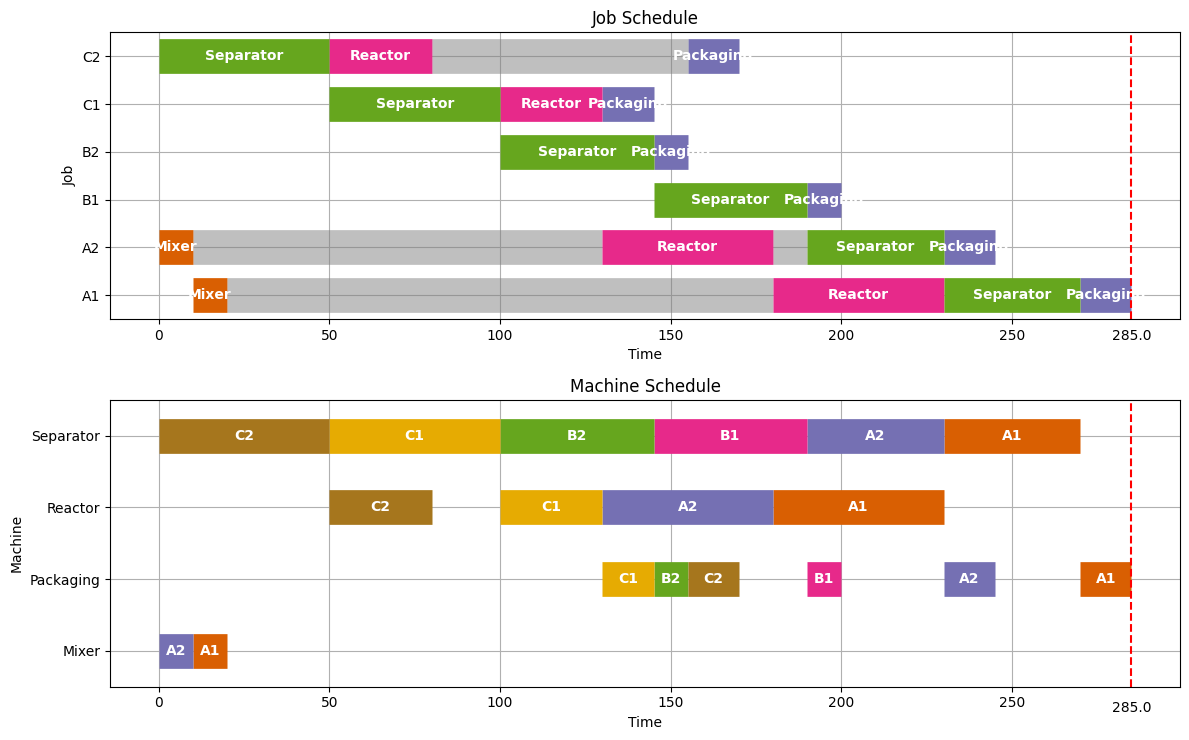

In [15]:
tasks = recipe_to_tasks(['A1','A2'],['Mixer','Reactor','Separator','Packaging'],[10,50,40,15])
tasks.update(recipe_to_tasks(['B1','B2'],['Separator','Packaging'],[45,10]))
tasks.update(recipe_to_tasks(['C1','C2'],['Separator','Reactor','Packaging'],[50,30,15]))

def mv_non_linear_func(x, z, gamma = 0.005):
    values = []
    for i in range(len(x)):
        xi = x[i]
        zi = 1.0 + gamma * (z[i] - 20)
        values.append(fobj_multivariate(100, xi, zi))
    return np.array(values)

linegrids = []
linegrids.append(np.linspace(0, makespan._ub, 10))
linegrids.append(np.linspace(0, makespan._ub, 10))
points = np.vstack(np.meshgrid(*linegrids)).reshape(2,-1).T

# create the model instance
triangulation = Delaunay(points)
tri_values = mv_non_linear_func(*points.T)

sc_nonlinear_mv = MultivariateNonLinearSchedulingProblem(dict(tri=triangulation, values=tri_values))
sc_nonlinear_mv.initialize(tasks)
results = sc_nonlinear_mv.solve(log=False, timeLimit=60)
sc_nonlinear_mv.visualize(results)
print(f'Objective: {sc_nonlinear_mv._model.objective()}')

The objective is 0.0, but that does not seem right. Let's evaluate the function at the optimal solution that was found. It doens't seem right, since the cost variable is always zero. Was the linearization not applied?  

In [18]:
for v in results:
    linearized = sc_nonlinear_mv._model.piecewise_A1_Mixer([v['Start'], v['Idle']])
    actual = mv_non_linear_func([v['Start']], [v['Idle']])[0]
    cost = sc_nonlinear_mv._model.cost[v['Job'], v['Machine']]()
    v['Cost(Linear)'] = linearized
    v['Cost(Actual)'] = actual
    v['Cost(Model)'] = cost

display(pd.DataFrame(results))

,Job,Machine,Start,Duration,Idle,Finish,End,Cost(Linear),Cost(Actual),Cost(Model)
0,A1,Mixer,10.0,10,160.0,20.0,180.0,21.978224,14.776916,0.0
1,A1,Reactor,180.0,50,0.0,230.0,230.0,235.939434,224.588002,0.0
2,A1,Separator,230.0,40,0.0,270.0,270.0,302.483158,286.973558,0.0
3,A1,Packaging,270.0,15,0.0,285.0,285.0,355.718137,336.882003,0.0
4,A2,Mixer,0.0,10,120.0,10.0,130.0,5.597616,0.000000,0.0
5,A2,Reactor,130.0,50,10.0,180.0,190.0,170.163676,164.656641,0.0
6,A2,Separator,190.0,40,0.0,230.0,230.0,249.248179,237.065113,0.0
7,A2,Packaging,230.0,15,0.0,245.0,245.0,302.483158,286.973558,0.0
8,B1,Separator,145.0,45,0.0,190.0,190.0,189.358828,180.918113,0.0
9,B1,Packaging,190.0,10,0.0,200.0,200.0,249.248179,237.065113,0.0
